In [8]:
import pandas as pd
from pathlib import Path

data_dir = Path("../data")

hr = pd.read_csv("../data/heart_rate_7users_daily_avgHR_CLEAN_v2.csv")
steps = pd.read_csv(data_dir / "steps_7users_overtrained_full.csv")

hr['calendar_date'] = pd.to_datetime(hr['calendar_date'])
steps['calendar_date'] = pd.to_datetime(steps['calendar_date'])

data = pd.merge(hr, steps[['sdv_user_id', 'calendar_date', 'steps', 'steps_goal']], on=['sdv_user_id', 'calendar_date'], how ='inner')

print("Merged shape:", data.shape)




Merged shape: (2555, 14)


In [9]:
#Add 5 class label

persona_map = {
    8101 : "high_workout",
    8102 : "high_workout",
    8103 : "healthy",
    8104 : "healthy",
    8105 : "low_workout",
    8106 : "lazy_obsese",
    8107 : "overtrained"
}

data["activity_label"] = data["sdv_user_id"].map(persona_map)
print("Value counts of activity_label:\n", data["activity_label"].value_counts())

Value counts of activity_label:
 activity_label
high_workout    730
healthy         730
low_workout     365
lazy_obsese     365
overtrained     365
Name: count, dtype: int64


In [19]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
feautures = [
    "steps",
    "average_stress_level",
    "heart_rate_per_point"
]

x = data[feautures]
y= data["activity_label"].copy()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

class_name = list(label_encoder.classes_)

print("Classes:", class_name)

Classes: ['healthy', 'high_workout', 'lazy_obsese', 'low_workout', 'overtrained']


In [20]:
#Train and Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    x, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)


In [21]:
#reshape for Conv1D

X_train_cnn = X_train_scaled.reshape(-1, 3, 1).astype("float32")
X_val_cnn   = X_val_scaled.reshape(-1, 3, 1).astype("float32")

y_train_cnn = y_train.astype("float32")
y_val_cnn   = y_val.astype("float32")

print(X_train_cnn.shape, X_val_cnn.shape)


(2044, 3, 1) (511, 3, 1)


In [23]:
#Build CNN (Conv1d)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout

input_shape = (3, 1)
num_classes = len(class_name)

model = Sequential([
    Conv1D(32, kernel_size=2, activation="relu", input_shape=input_shape),
    Conv1D(64, kernel_size=2, activation="relu"),
    GlobalAveragePooling1D(),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                        

In [24]:
#Compile and train
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 1.4362 - accuracy: 0.5406 - val_loss: 1.2109 - val_accuracy: 0.7280
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.9838 - accuracy: 0.7084 - val_loss: 0.7185 - val_accuracy: 0.7436
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6396 - accuracy: 0.7608 - val_loss: 0.5029 - val_accuracy: 0.7965
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5190 - accuracy: 0.7994 - val_loss: 0.4098 - val_accuracy: 0.8395
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.4254 - accuracy: 0.8356 - val_loss: 0.3411 - val_accuracy: 0.8630
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.3622 - accuracy: 0.8454 - val_loss: 0.2848 - val_accuracy: 0.8904
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.3033 - accuracy: 0.8831 - val_loss: 0.2543 - val_accuracy: 0.8924
Epoch 8/50
32/32 [=

In [36]:
# Save model + scaler + label encoder

import joblib

# Recommended: new Keras format
model.save("activity_cnn_5classes_v2.keras")

joblib.dump(scaler, "scaler_activity_v2.pkl")
joblib.dump(label_encoder, "label_encoder_activity_v2.pkl")

print("Saved:",
      "activity_cnn_5classes_v2.keras,",
      "scaler_activity_v2.pkl,",
      "label_encoder_activity_v2.pkl")


Saved: activity_cnn_5classes_v2.keras, scaler_activity_v2.pkl, label_encoder_activity_v2.pkl


16/16 [==============================] - 0s 2ms/step
Validation accuracy: 0.9784735812133072


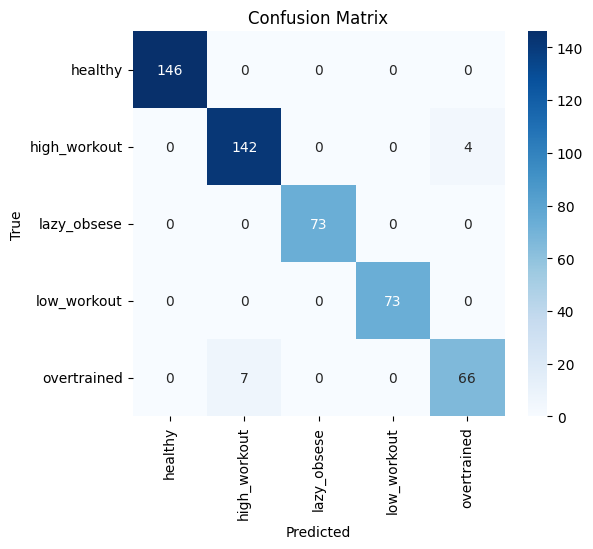

In [26]:
#Evaluate (accuracy + confusion matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_val_probs = model.predict(X_val_cnn)
y_val_pred = np.argmax(y_val_probs, axis=1)

print("Validation accuracy:", accuracy_score(y_val_cnn, y_val_pred))

cm = confusion_matrix(y_val_cnn, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_name, yticklabels=class_name, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [27]:
def predict_activity_for_row_keras(row, model, scaler, label_encoder, feature_cols):
    x = row[feature_cols].to_numpy().astype("float32").reshape(1, -1)
    x_scaled = scaler.transform(x)
    x_cnn = x_scaled.reshape(1, 3, 1)
    probs = model.predict(x_cnn, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    return pred_label, probs


def generate_feedback(row, predicted_label, probs):
    steps  = float(row["steps"])
    stress = float(row["average_stress_level"])
    hr_avg = float(row["heart_rate_per_point"])
    confidence = float(np.max(probs)) * 100

    summary = (
        f"Today: {steps:.0f} steps, stress {stress:.1f}, "
        f"average HR {hr_avg:.1f} bpm.\n\n"
    )

    if predicted_label == "over_trained":
        msg = (
            "You are very active, but your stress and heart signals look high. "
            "Consider a lighter day, more sleep, hydration, and recovery activities."
        )
    elif predicted_label == "high_workout":
        msg = (
            "Strong activity level. Keep it up, and make sure you include recovery days "
            "to stay consistent long-term."
        )
    elif predicted_label == "healthy":
        msg = (
            "Nice balance between activity, stress, and heart rate. "
            "Maintaining this routine is a great long-term strategy."
        )
    elif predicted_label == "low_activity":
        msg = (
            "Your movement is a bit low today. A short walk (10–20 minutes) is already enough "
            "to improve energy and support heart health."
        )
    else:  # lazy_obese
        msg = (
            "Start small and consistent. Even a few short walks per day can help a lot. "
            "Focus on building a habit rather than big changes."
        )

    return summary + msg + f"\n\nModel confidence for '{predicted_label}': {confidence:.1f}%."


In [31]:
import numpy as np
import pandas as pd

def classify_and_feedback(
    steps,
    stress,
    hr_avg,
    model,
    scaler,
    label_encoder
):
    """
    Manual input classification + feedback

    Parameters
    ----------
    steps : int or float
        Daily steps
    stress : int or float
        Average stress level (0–100)
    hr_avg : int or float
        Daily average heart rate (heart_rate_per_point)

    Returns
    -------
    pred_label : str
    probs_dict : dict
    """

    feature_cols = ["steps", "average_stress_level", "heart_rate_per_point"]

    # ---------- Prepare input ----------
    row_df = pd.DataFrame([{
        "steps": float(steps),
        "average_stress_level": float(stress),
        "heart_rate_per_point": float(hr_avg),
    }], columns=feature_cols)

    x_scaled = scaler.transform(row_df)
    x_cnn = x_scaled.reshape(1, 3, 1).astype("float32")

    # ---------- Predict ----------
    probs = model.predict(x_cnn, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]

    confidence = float(np.max(probs)) * 100

    # ---------- Feedback ----------
    summary = (
        f"Input summary:\n"
        f"- Steps: {steps:.0f}\n"
        f"- Stress level: {stress:.1f}\n"
        f"- Average heart rate: {hr_avg:.1f} bpm\n\n"
    )

    if pred_label == "over_trained":
        msg = (
            "You are training very hard and your stress and heart signals are high. "
            "This may indicate that your body is not fully recovering. "
            "Consider adding a lighter day, more sleep, hydration, and recovery activities."
        )
    elif pred_label == "high_workout":
        msg = (
            "You have a high activity level and your cardiovascular system is working well. "
            "This is great for fitness. Remember to balance hard training with proper recovery."
        )
    elif pred_label == "healthy":
        msg = (
            "Your activity, stress, and heart rate are well balanced. "
            "This is a strong and sustainable health pattern. Keep it consistent."
        )
    elif pred_label == "low_activity":
        msg = (
            "Your movement level is a bit low. Even a short walk or light exercise "
            "for 10–20 minutes can already improve your energy and long-term health."
        )
    else:  # lazy_obese
        msg = (
            "Your activity level is quite low and your heart is working relatively hard. "
            "Start with small, realistic goals such as short walks during the day. "
            "Small and consistent steps are the key to lasting improvement."
        )

    feedback_text = (
        summary
        + f"Predicted class: {pred_label}\n"
        + f"Model confidence: {confidence:.1f}%\n\n"
        + msg
    )

    # ---------- Print ----------
    print(feedback_text)

    probs_dict = {
        cls: float(p) for cls, p in zip(label_encoder.classes_, probs)
    }

    return pred_label, probs_dict


In [35]:
pred, probs = classify_and_feedback(
    steps=19000,
    stress=30,
    hr_avg=130,
    model=model,
    scaler=scaler,
    label_encoder=label_encoder
)

print("\nProbabilities per class:")
for k, v in probs.items():
    print(f"{k:12s}: {v:.3f}")


Input summary:
- Steps: 19000
- Stress level: 30.0
- Average heart rate: 130.0 bpm

Predicted class: high_workout
Model confidence: 99.9%

You have a high activity level and your cardiovascular system is working well. This is great for fitness. Remember to balance hard training with proper recovery.

Probabilities per class:
healthy     : 0.001
high_workout: 0.999
lazy_obsese : 0.000
low_workout : 0.000
overtrained : 0.000
